# Import packages

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, plot_confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.metrics import Recall, Precision

import random
import os
import glob
from pathlib import Path

%matplotlib inline

# Paths

In [2]:
# local path
user_path = Path('/Users/mkv/code/mkvph0ch/memobrain/')
# google cloud storage bucket path
gcp_path = 'gs://memobrain/raw_data/'

# Load Metadata

## OASIS1

In [6]:
# load metadata OASIS1
oas1_meta_file = user_path.joinpath('raw_data/OASIS1/oasis_cross-sectional.csv')

# load to pandas df, show head
oas1_meta_df = pd.read_csv(oas1_meta_file)
oas1_meta_df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [10]:
oas1_meta = oas1_meta_df.copy().drop(columns=['Hand', 'Educ', 'Delay'])

In [13]:
oas1_meta.dropna(subset = ["CDR"], axis=0, inplace=True)

In [14]:
oas1_meta.isna().sum()

ID       0
M/F      0
Age      0
SES     19
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [18]:
oas1_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [24]:
oas1_meta['SES'] = oas1_mean.fit_transform(oas1_meta['SES'].values.reshape(-1, 1))

In [26]:
oas1_meta.isna().sum()

ID      0
M/F     0
Age     0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

## OASIS2

In [9]:
# load metadata OASIS2
oas2_meta_file = user_path.joinpath('raw_data/OASIS2/oasis_longitudinal_demographics.xlsx')

# load to pandas df, show head
oas2_meta_df = pd.read_excel(oas2_meta_file)
oas2_meta_df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [15]:
oas2_meta = oas2_meta_df.copy().drop(columns=['Subject ID', 'Group', 'Visit', 'MR Delay', 'Hand', 'EDUC'])

In [16]:
oas2_meta.isna().sum()

MRI ID     0
M/F        0
Age        0
SES       19
MMSE       2
CDR        0
eTIV       0
nWBV       0
ASF        0
dtype: int64

In [28]:
oas2_ses = SimpleImputer(missing_values=np.nan, strategy='mean')
oas2_meta['SES'] = oas2_ses.fit_transform(oas2_meta['SES'].values.reshape(-1, 1))

oas2_mmse = SimpleImputer(missing_values=np.nan, strategy='mean')
oas2_meta['MMSE'] = oas2_mmse.fit_transform(oas2_meta['MMSE'].values.reshape(-1, 1))

In [29]:
oas2_meta.isna().sum()

MRI ID    0
M/F       0
Age       0
SES       0
MMSE      0
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

## Merge OASIS1+2

In [40]:
oas1_meta.shape

(235, 9)

In [41]:
oas2_meta.shape

(373, 9)

In [31]:
oas1_meta.columns

Index(['ID', 'M/F', 'Age', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'], dtype='object')

In [32]:
oas2_meta.columns

Index(['MRI ID', 'M/F', 'Age', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'], dtype='object')

In [34]:
oas2_meta.rename(columns={"MRI ID": "ID"}, inplace=True)
oas2_meta.columns

Index(['ID', 'M/F', 'Age', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'], dtype='object')

In [36]:
assert(oas1_meta.columns.all() == oas2_meta.columns.all())

In [43]:
oas_concat = pd.concat([oas1_meta, oas2_meta])

In [48]:
assert (oas1_meta.shape[0] + oas2_meta.shape[0] == oas_concat.shape[0])

In [49]:
oas_concat.head()

,ID,M/F,Age,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,3.0,29.0,0.0,1344.0,0.743,1.306
1,OAS1_0002_MR1,F,55,1.0,29.0,0.0,1147.0,0.810,1.531
2,OAS1_0003_MR1,F,73,3.0,27.0,0.5,1454.0,0.708,1.207
8,OAS1_0010_MR1,M,74,2.0,30.0,0.0,1636.0,0.689,1.073
9,OAS1_0011_MR1,F,52,2.0,30.0,0.0,1321.0,0.827,1.329


# Preprocessing

In [55]:
def binary_target(value):
    '''convert all dementia to 1, leave no dementia to 0'''
    if value != 0:
        return 1
    else:
        return value

In [56]:
def binary_sex(value):
    '''convert male to 1, female to 0'''
    if value == 'M':
        return 1
    elif value == 'F':
        return 0

In [57]:
oas_concat['CDR'] = oas_concat['CDR'].apply(lambda x: binary_target(x))

In [58]:
oas_concat['M/F'] = oas_concat['M/F'].apply(lambda x: binary_sex(x))

In [59]:
oas_concat.head()

,ID,M/F,Age,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,0,74,3.0,29.0,0.0,1344.0,0.743,1.306
1,OAS1_0002_MR1,0,55,1.0,29.0,0.0,1147.0,0.810,1.531
2,OAS1_0003_MR1,0,73,3.0,27.0,1.0,1454.0,0.708,1.207
8,OAS1_0010_MR1,1,74,2.0,30.0,0.0,1636.0,0.689,1.073
9,OAS1_0011_MR1,0,52,2.0,30.0,0.0,1321.0,0.827,1.329


# RandomForest

In [61]:
X_meta = oas_concat.drop(columns=['CDR', 'ID']).values
y_meta = oas_concat['CDR'].values

In [62]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, random_state = 42)

In [63]:
RanFor = RandomForestClassifier(max_depth = 2, n_estimators = 15)

RanFor.fit(X_train_meta, y_train_meta)

print ("Training score: " + str(round(RanFor.score(X_train_meta, y_train_meta)*100,2)) + '%')
print ("Test score: " + str(round(RanFor.score(X_test_meta, y_test_meta)*100,2)) + '%')

Training score: 83.11%
Test score: 82.24%


## GridSearchCV

In [66]:
random_trees, random_depths =  random.sample(range(1,20),10), random.sample(range(1,50),25)

### Accuracy

In [69]:
params = {
    'n_estimators': random_trees,
    'max_depth': random_depths
}

grid = GridSearchCV(RanFor, 
                    param_grid=params,
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=5)

grid.fit(X_train_meta, y_train_meta)

print("Best score: " + str(round(grid.best_score_*100,2)) + '%', str(grid.best_params_))

Best score: 87.72% {'max_depth': 18, 'n_estimators': 18}


In [70]:
final_acc_model = grid.best_estimator_
final_acc_model.fit(X_train_meta, y_train_meta)

print ("Training score: " + str(final_acc_model.score(X_train_meta, y_train_meta)))
print ("Test score: " + str(final_acc_model.score(X_test_meta, y_test_meta)))

Training score: 1.0
Test score: 0.9276315789473685


In [87]:
meta_pred = final_acc_model.predict(X_test_meta)

print("Accuracy score: ", round((accuracy_score(y_test_meta, meta_pred))*100, 2))
print("Recall score: ", round((recall_score(y_test_meta, meta_pred))*100, 2))
print("Precision score: ", round((precision_score(y_test_meta, meta_pred))*100, 2))

Accuracy score:  92.76
Recall score:  84.51
Precision score:  100.0


### Recall

In [81]:
params = {
    'n_estimators': random_trees,
    'max_depth': random_depths
}

grid_recall = GridSearchCV(RanFor, 
                    param_grid=params,
                    scoring='recall',
                    n_jobs=-1,
                    cv=5)

grid_recall.fit(X_train_meta, y_train_meta)

print("Best score: " + str(round(grid_recall.best_score_*100,2)) + '%', str(grid_recall.best_params_))

Best score: 82.15% {'max_depth': 47, 'n_estimators': 15}


In [82]:
final_rec_model = grid_recall.best_estimator_
final_rec_model.fit(X_train_meta, y_train_meta)

print ("Training score: " + str(final_rec_model.score(X_train_meta, y_train_meta)))
print ("Test score: " + str(final_rec_model.score(X_test_meta, y_test_meta)))

Training score: 0.9978070175438597
Test score: 0.881578947368421


In [85]:
meta_rec_pred = final_rec_model.predict(X_test_meta)

print("Accuracy score: ", round((accuracy_score(y_test_meta, meta_rec_pred))*100, 2))
print("Recall score: ", round((recall_score(y_test_meta, meta_rec_pred))*100, 2))
print("Precision score: ", round((precision_score(y_test_meta, meta_rec_pred))*100, 2))

Accuracy score:  88.16
Recall score:  78.87
Precision score:  94.92


## Confusion Matrix

In [78]:
def plot_cf_matrix(cf_matrix, model_name):
    '''plt the confusion matrix of a model'''
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    plt.title(model_name)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    return None

### Accuracy Model

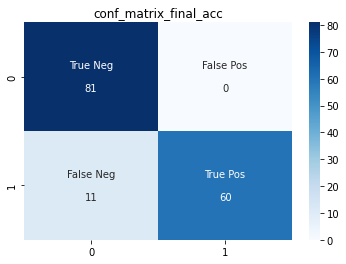

In [80]:
conf_matrix_final_acc = confusion_matrix(y_true=y_test_meta, y_pred=meta_pred)

plot_cf_matrix(conf_matrix_final_acc, 'conf_matrix_final_acc')

### Recall Model

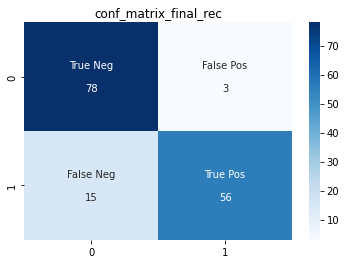

In [84]:
conf_matrix_final_rec = confusion_matrix(y_true=y_test_meta, y_pred=meta_rec_pred)

plot_cf_matrix(conf_matrix_final_rec, 'conf_matrix_final_rec')